# Generate input data for classifier

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Source of data
- NSUN2-dependent sites
  1. Noc-treated HeLa (KO vs WT)
  2. Untreated HeLa (KO vs WT)
  3. Untreated HEK293T (KO vs WT)
- NSUN6-dependent sites
  1. Noc-treated HeLa (KO vs WT)
  2. Untreated HeLa (KO vs WT)
  3. Untreated HEK293T (KO vs WT)
  4. Untreated HepG2 (KO vs WT)
- NSUN5-dependent sites
  1. Noc-treated HeLa (KO vs WT)
  2. LN229 (OE vs EV) 
- Nop2-dependent sites
  1. Noc-treated HeLa (siNop2 vs WT)
 
LN229 data is from Janin et al. (doi.org:10.1007/s00401-019-02062-4).

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1 or 1.7.3
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- Biopython==1.77

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import warnings
from Bio import SeqIO
from Bio.Seq import reverse_complement
from collections import defaultdict
import h5py
from IPython.display import Image

warnings.filterwarnings('ignore')

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

## 1. Process Noc-treated HeLa

In [2]:
df_Noc = pd.read_csv("HeLa_Noc_NSUNs.motif.F10.csv", index_col=[0,1,2], header=[0,1])
df_Noc = df_Noc[df_Noc[("WT_Noc", "passed")]==True]
df_Noc[("INFO", "group")] = "unknown"

In [3]:
def cal_index(SUB, ctrl_1, ctrl_2, ctrl_3, target):
    '''
This function compute if the site is purely methylated by one enzyme:
(1) list all coverage and level information of the site, and find out in which sample we detect it;
(2) calculate Fisher's exact test pvalue for each experimental group, compared with WT cells;
(3) the site should have lowest level and pvalue among all tested data.
    '''
    indexes = []
    SUB = SUB[["WT_Noc", "si_N1", "KO_N2", "KO_N5", "KO_N6", "INFO"]]
    SUB[("INFO", "MIN")] = SUB.xs("m5C level", axis=1, level=1).min(axis=1)
    SUB[("INFO", "COV_MIN")] =  SUB.xs("coverage", axis=1, level=1).min(axis=1)
    SUB = SUB.loc[SUB[("INFO", "COV_MIN")]>0]
    SUB = SUB.loc[SUB[(target, "m5C level")]==SUB[("INFO", "MIN")]]

    for idx, row in SUB.iterrows():
        used = True
        t = row[(target, "coverage")]
        c = row[(target, "C count")]
        pvalues = []
        if row[("WT_Noc", "coverage")] >= 10:
            T = row[("WT_Noc", "coverage")]
            C = row[("WT_Noc", "C count")]
            odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative="less")
            pvalues.append(pvalue)
        if row[(ctrl_1, "coverage")] >= 10:
            T = row[(ctrl_1, "coverage")]
            C = row[(ctrl_1, "C count")]
            odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative="less")
            pvalues.append(pvalue)
        if row[(ctrl_2, "coverage")] >= 10:
            T = row[(ctrl_2, "coverage")]
            C = row[(ctrl_2, "C count")]
            odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative="less")
            pvalues.append(pvalue)
        if row[(ctrl_3, "coverage")] >= 10:
            T = row[(ctrl_3, "coverage")]
            C = row[(ctrl_3, "C count")]
            odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative="less")
            pvalues.append(pvalue)
        if max(pvalues) >= 0.1 or min(pvalues) >= 0.05:
            used = False
        if used == True:
            indexes.append(idx)
    return indexes

In [4]:
NSUN6 = cal_index(df_Noc, "KO_N2", "KO_N5", "si_N1", "KO_N6")
print("NSUN6: {}".format(len(NSUN6)))

NSUN6: 64


In [5]:
NSUN2 = cal_index(df_Noc, "KO_N6", "KO_N5", "si_N1", "KO_N2")
print("NSUN2: {}".format(len(NSUN2)))

NSUN2: 2167


In [6]:
NSUN5 = cal_index(df_Noc, "KO_N2", "KO_N6", "si_N1", "KO_N5")
print("NSUN5: {}".format(len(NSUN5)))

NSUN5: 61


In [7]:
Nop2 = cal_index(df_Noc, "KO_N2", "KO_N5", "KO_N6", "si_N1")
print("Nop2: {}".format(len(Nop2)))

Nop2: 124


In [8]:
df_Noc.loc[NSUN2, ("INFO", "NSUN2")] = 1
df_Noc.loc[NSUN5, ("INFO", "NSUN5")] = 1
df_Noc.loc[NSUN6, ("INFO", "NSUN6")] = 1
df_Noc.loc[Nop2, ("INFO", "Nop2")] = 1
df_Noc.loc[NSUN2, ("INFO", "group")] = "NSUN2"
df_Noc.loc[NSUN5, ("INFO", "group")] = "NSUN5"
df_Noc.loc[NSUN6, ("INFO", "group")] = "NSUN6"
df_Noc.loc[Nop2, ("INFO", "group")] = "Nop2"

In [9]:
with open("HeLa_Noc_Nop2.txt", "w") as out1,\
     open("HeLa_Noc_NSUN2.txt", "w") as out2,\
     open("HeLa_Noc_NSUN6.txt", "w") as out3,\
     open("HeLa_Noc_NSUN5.txt", "w") as out4:
    for idx, row in df_Noc[df_Noc[("INFO", "group")]!="unknown"].iterrows():
        if row[("INFO", "group")] == "Nop2":
            out1.write("{}\tNop2\n".format(idx[0]))
        elif row[("INFO", "group")] == "NSUN2":
            out2.write("{}\tNSUN2\n".format(idx[0]))
        elif row[("INFO", "group")] == "NSUN6" and row[("INFO", "motif_1")] in ["TCCA", "TCTA", "TCGA", "TCAA"]:
            out3.write("{}\tNSUN6\n".format(idx[0]))
        elif row[("INFO", "group")] == "NSUN5":
            out4.write("{}\tNSUN5\n".format(idx[0]))

df_Noc.to_csv("HeLa_Noc_NSUNs.motif.F10.input_data.csv")

## 2. Process data in untreated cells

In [10]:
df_cells = pd.read_csv("293T_HeLa_HepG2_KO_N2_N6.motif.csv", index_col=[0,1,2], header=[0,1])

In [11]:
def fisher(used, row, t, c, key):
    if used == False:
        return False
    if row[(key, "coverage")] >= 10:
        T = row[(key, "coverage")]
        C = row[(key, "C count")]
        odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative="less")
        # print(t, c, T, C ,pvalue)
        if pvalue >= 0.05:
            used = False
        else:
            used = True
    return used

In [12]:
def cal_index_293T_NSUN2(SUB):
    indexes = []
    exclued = []
    SUB = SUB.loc[((SUB[("293T", "passed")] == True)| (SUB[("293T_KO_N6", "passed")] == True))& (SUB[("293T_KO_N2", "m5C level")] < 0.05)]
    print(SUB.shape)
    for idx, row in SUB.iterrows():
        used = True
        t = row[("293T_KO_N2", "coverage")]
        c = row[("293T_KO_N2", "C count")]
        used =  fisher(used, row, t, c, "293T")
        used =  fisher(used, row, t, c, "293T_KO_N6")
        if used == True:
            indexes.append(idx)
        else:
            exclued.append(idx)
    return indexes, exclued

In [13]:
def cal_index_293T_NSUN6(SUB):
    indexes = []
    exclued = []
    SUB = SUB.loc[((SUB[("293T", "passed")] == True)| (SUB[("293T_KO_N2", "passed")] == True)) & (SUB[("293T_KO_N6", "m5C level")] < 0.05)]
    print(SUB.shape)
    for idx, row in SUB.iterrows():
        used = True

        t = row[("293T_KO_N6", "coverage")]
        c = row[("293T_KO_N6", "C count")]

        used =  fisher(used, row, t, c, "293T")
        used =  fisher(used, row, t, c, "293T_KO_N2")
        if row[("INFO", "motif")] not in ["TCCA", "TCTA", "TCGA", "TCAA"]:
            used = False

        if used == True:
            indexes.append(idx)
        else:
            exclued.append(idx)
    return indexes, exclued

In [14]:
def cal_index_HeLa_NSUN2(SUB):
    indexes = []
    exclued = []
    SUB = SUB.loc[((SUB[("HeLa_KO_N2", "passed")] == True)| (SUB[("HeLa_KO_N6", "passed")] == True)) & (SUB[("HeLa_KO_N2", "m5C level")] < 0.05)]
    print(SUB.shape)
    for idx, row in SUB.iterrows():
        used = True
        t = row[("HeLa_KO_N2", "coverage")]
        c = row[("HeLa_KO_N2", "C count")]

        used =  fisher(used, row, t, c, "HeLa")
        used =  fisher(used, row, t, c, "HeLa_KO_N6")

        if used == True:
            indexes.append(idx)
        else:
            exclued.append(idx)
    return indexes, exclued

In [15]:
def cal_index_HeLa_NSUN6(SUB):
    indexes = []
    exclued = []
    SUB = SUB.loc[(SUB[("HeLa", "passed")] == True) & (SUB[("HeLa_KO_N2", "m5C level")] < 0.05)]
    print(SUB.shape)
    for idx, row in SUB.iterrows():
        used = True
        t = row[("HeLa_KO_N6", "coverage")]
        c = row[("HeLa_KO_N6", "C count")]

        used =  fisher(used, row, t, c, "HeLa")
        used =  fisher(used, row, t, c, "HeLa_KO_N2")
        if row[("INFO", "motif")] not in ["TCCA", "TCTA", "TCGA", "TCAA"]:
            used = False

        if used == True:
            indexes.append(idx)
        else:
            exclued.append(idx)
    return indexes, exclued

In [16]:
def cal_index_HepG2_NSUN6(SUB):
    indexes = []
    exclued = []
    SUB = SUB.loc[(SUB[("HepG2", "passed")] == True) & (SUB[("HepG2_KO_N6", "m5C level")] < 0.05)]
    print(SUB.shape)
    for idx, row in SUB.iterrows():
        used = True
        t = row[("HepG2_KO_N6", "coverage")]
        c = row[("HepG2_KO_N6", "C count")]
        used =  fisher(used, row, t, c, "HepG2")
        if row[("INFO", "motif")] not in ["TCCA", "TCTA", "TCGA", "TCAA"]:
            used = False
        if used == True:
            indexes.append(idx)
        else:
            exclued.append(idx)
    return indexes, exclued

In [17]:
# use NSUN2/NSUN6 dual KO results as a filter
dual_KO_index = set(df_cells.loc[(df_cells[("293T_KO_N26", "passed")] == True) | (df_cells[("293T_KO_N26", "m5C level")] >= 0.05) ].index.tolist())

In [18]:
HEK293T_NSUN2, HEK293T_NSUN2_excluded = cal_index_293T_NSUN2(df_cells)
HEK293T_NSUN6, HEK293T_NSUN6_excluded = cal_index_293T_NSUN6(df_cells)
HeLa_NSUN2, HeLa_NSUN2_excluded = cal_index_HeLa_NSUN2(df_cells)
HeLa_NSUN6, HeLa_NSUN6_excluded = cal_index_HeLa_NSUN6(df_cells)
HepG2_NSUN6, HepG2_NSUN6_excluded =cal_index_HepG2_NSUN6(df_cells)

(242, 55)
(173, 55)
(619, 55)
(572, 55)
(238, 55)


In [19]:
NSUN2 = set(HEK293T_NSUN2) | set(HeLa_NSUN2) - dual_KO_index
NSUN6 = set(HEK293T_NSUN6) | set(HeLa_NSUN6) | set(HepG2_NSUN6) - dual_KO_index
common_index = NSUN2 & NSUN6
print("NSUN2: {}".format(len(NSUN2)))
print("NSUN6: {}".format(len(NSUN6)))
print("Common: {}".format(len(common_index)))

NSUN2: 574
NSUN6: 181
Common: 0


In [20]:
NSUN2 = list(NSUN2 - common_index)
NSUN6 = list(NSUN6 - common_index)
print("After overlap clean up")
print("NSUN2: {}".format(len(NSUN2)))
print("NSUN6: {}".format(len(NSUN6)))

After overlap clean up
NSUN2: 574
NSUN6: 181


In [21]:
df_cells[("INFO", "group")] = "unknown"
df_cells.loc[NSUN2, ("INFO", "group")] = "NSUN2"
df_cells.loc[NSUN6, ("INFO", "group")] = "NSUN6"
df_cells.loc[common_index, ("INFO", "group")] = "Confused"
df_cells.to_csv("cell_line_KO.csv")

with open("Cells_NSUN2.txt", "w") as out2,\
    open("Cells_NSUN6.txt", "w") as out3:
    for idx, row in df_cells[df_cells[("INFO", "group")]!="unknown"].iterrows():
        if row[("INFO", "group")] == "NSUN2":
            out2.write("{}\tNSUN2\n".format(idx[0]))
        elif row[("INFO", "group")] == "NSUN6":
            out3.write("{}\tNSUN6\n".format(idx[0]))

## 3. Analyze and process LN229 data

In [22]:
df_LN229 = pd.read_csv("LN229_NSUN5.motif.csv", index_col=[0,1,2], header=[0,1])

In [23]:
def fisher_plot(row, X, Y, alternative="less"):
    if row[(X, "coverage")] >= 20 and row[(Y, "coverage")] >= 20:
        T = row[(X, "coverage")]
        C = row[(X, "C count")]
        t = row[(Y, "coverage")]
        c = row[(Y, "C count")]
        odds,pvalue = scipy.stats.fisher_exact([[c, C],[t-c, T-C]], alternative=alternative)
        return pvalue
    else:
        return 1

In [24]:
df_LN229[("INFO", "pvalue")] = df_LN229.apply(lambda x: fisher_plot(x, "LN229_EV", "LN229_OE", alternative="greater"), axis=1)
df_LN229[("INFO", "group")] = "unknown"
indexes = df_LN229[df_LN229[("INFO", "pvalue")]<0.05].index
df_LN229.loc[indexes, ("INFO", "group")] = "NSUN5"
df_LN229.to_csv("NSUN5.inter.motif.group.csv")
with open("LN229_NSUN5.txt", "w") as out:
    for idx, row in df_LN229.iterrows():
        if row[("INFO", "group")] == "NSUN5":
            out.write("{}\tNSUN5\n".format(idx[0]))
print("NSUN5: {} of {}".format(len(indexes), df_LN229.shape[0]))

NSUN5: 2035 of 2548


In [25]:
def draw_one(ax, df, X, Y, indexes=None, alternative="less", draw_cbar=False, xlabel=None, ylabel=None):
    df = df.copy()
    indexes_used = []
    if indexes is not None:
        for idx, row in df.iterrows():
            if idx[0] in indexes:
                indexes_used.append(idx)
        df = df.loc[indexes_used]
    df = df[(df[(X, "coverage")]>=20)&(df[(Y, "coverage")]>=20)]
    if df.shape[0] > 0:
        df[("INFO", "pvalue")] = df.apply(lambda x: fisher_plot(x, X, Y, alternative=alternative), axis=1)
    
        ax.set_aspect('equal', 'box')

        scatter= ax.scatter(x=df[(X, "m5C level")],
                      y=df[(Y, "m5C level")],
                      alpha=1.0, s=3,
                      c=df[("INFO","pvalue")],
                      norm=LogNorm(vmin=0.001, vmax=1.0))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        Line1 = Line2D(ax.get_xlim(),ax.get_ylim(),color='k',linestyle='--',alpha=1,linewidth=0.8)
        ax.add_line(Line1)
        if draw_cbar == True:
            cbar = plt.colorbar(scatter)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        Line1 = Line2D(ax.get_xlim(),ax.get_ylim(),color='k',linestyle='--',alpha=1,linewidth=0.8)
        ax.add_line(Line1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

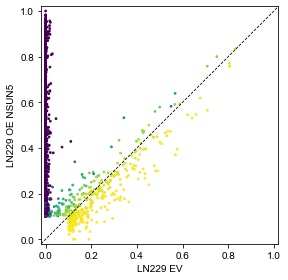

In [26]:
fig,ax = plt.subplots()
draw_one(ax, df_LN229,"LN229_EV", "LN229_OE", alternative="greater", draw_cbar=False, xlabel="LN229 EV", ylabel= "LN229 OE NSUN5")
plt.tight_layout()

## 4. Concaterate lists and store them into .h5 file

### 4.1 Load lists

In [27]:
NSUN2_sites = []
NSUN6_sites = []
NSUN5_sites = []
Nop2_sites = []
def load_data_from_table(fn):
    with open(fn, "r") as input:
        for line in input.readlines():
            line = line.strip().split("\t")
            site, group = line
            if group == "NSUN2":
                NSUN2_sites.append(site)
            elif group == "NSUN6":
                NSUN6_sites.append(site)
            elif group == "NSUN5":
                NSUN5_sites.append(site)
            elif group == "Nop2":
                Nop2_sites.append(site)

In [28]:
for fn in ["Cells_NSUN2.txt", "HeLa_Noc_Nop2.txt", "HeLa_Noc_NSUN5.txt", "LN229_NSUN5.txt", "Cells_NSUN6.txt", "HeLa_Noc_NSUN2.txt", "HeLa_Noc_NSUN6.txt"]:
    load_data_from_table(fn)

In [29]:
# clean overlaps
NSUN2_sites = set(NSUN2_sites)
NSUN6_sites = set(NSUN6_sites)
NSUN5_sites = set(NSUN5_sites)
Nop2_sites = set(Nop2_sites)

NSUN2_filtered = NSUN2_sites - Nop2_sites - NSUN5_sites - NSUN6_sites
NSUN6_filtered = NSUN6_sites - Nop2_sites - NSUN5_sites - NSUN2_sites
NSUN5_filtered = NSUN5_sites - Nop2_sites - NSUN2_sites - NSUN6_sites
Nop2_filtered  = Nop2_sites  - NSUN6_sites - NSUN5_sites - NSUN2_sites

print("NSUN2: {}".format(len(NSUN2_filtered)))
print("NSUN6: {}".format(len(NSUN6_filtered)))
print("NSUN5: {}".format(len(NSUN5_filtered)))
print("Nop2: {}".format(len(Nop2_filtered)))

NSUN2: 2493
NSUN6: 200
NSUN5: 2058
Nop2: 124


### 4.2 Get flanking 10-nt sequences and one-hot encoding

In [30]:
ref_genome = "Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.format.fa"
ref_genome_seq = {}
for seq in SeqIO.parse(ref_genome, "fasta"):
    ref_genome_seq[str(seq.id)] = str(seq.seq).upper()

In [31]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

OneHotEncoder(dtype=<class 'numpy.int8'>)

In [32]:
def get_flanking_sequences(chr, pos, strand):
    '''
    pos should be 1-based
    '''
    seq_F10 = ref_genome_seq[chr][pos-11: pos+10]
    if len(seq_F10) != 21:
        raise ValueError("Sequence length != 21")
    if strand == "-":
        seq_F10 = reverse_complement(seq_F10)
    onehot_encoded = enc.transform(np.array([[i] for i in seq_F10])).toarray()
    if seq_F10[10] != "C":
        raise ValueError("Center not C")
    return seq_F10, onehot_encoded

In [33]:
IDs = []
Labels_int = []
Labels_onehot = []
Sequences_onehot = []
N = 0
for sites, label in zip(*[[NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], 
                  ["NSUN2", "NSUN6", "NSUN5", "Nop2"]]):
    with open("{}.F10.fa".format(label), "w") as fasta_out:
        for site in sites:
            chr, pos, strand = site.split("@")
            pos = int(pos)
            seq, onehot = get_flanking_sequences(chr, pos, strand)

            if label == "NSUN6":
                label_int = 0
                label_onehot = [1, 0, 0, 0]
            elif label == "NSUN2":
                label_int = 1
                label_onehot = [0, 1, 0, 0]
            elif label == "NSUN5":
                label_int = 2
                label_onehot = [0, 0, 1, 0]
            elif label == "Nop2":
                label_int = 3
                label_onehot = [0, 0, 0, 1]
            else:
                print(site, label)
            N += 1
            IDs.append(N)
            Labels_int.append(label_int)
            Labels_onehot.append(label_onehot)
            Sequences_onehot.append(onehot)
            fasta_out.write(">{}\n{}\n".format(site, seq))

**Draw logos (require Weblogo)**

In [34]:
!weblogo -A dna -y Frequency -D fasta -F pdf --color-scheme classic --units probability --composition none -P NSUN2 -i -10 -f NSUN2.F10.fa > NSUN2.F10.pdf
!weblogo -A dna -y Frequency -D fasta -F pdf --color-scheme classic --units probability --composition none -P NSUN6 -i -10 -f NSUN6.F10.fa > NSUN6.F10.pdf
!weblogo -A dna -y Frequency -D fasta -F pdf --color-scheme classic --units probability --composition none -P NSUN5 -i -10 -f NSUN5.F10.fa > NSUN5.F10.pdf
!weblogo -A dna -y Frequency -D fasta -F pdf --color-scheme classic --units probability --composition none -P Nop2 -i -10 -f Nop2.F10.fa > Nop2.F10.pdf

In [35]:
!weblogo -A dna -y Frequency -D fasta -F png --resolution 1000 --color-scheme classic --units probability --composition none -P NSUN2 -i -10 -f NSUN2.F10.fa > NSUN2.F10.png
!weblogo -A dna -y Frequency -D fasta -F png --resolution 1000 --color-scheme classic --units probability --composition none -P NSUN6 -i -10 -f NSUN6.F10.fa > NSUN6.F10.png
!weblogo -A dna -y Frequency -D fasta -F png --resolution 1000 --color-scheme classic --units probability --composition none -P NSUN5 -i -10 -f NSUN5.F10.fa > NSUN5.F10.png
!weblogo -A dna -y Frequency -D fasta -F png --resolution 1000 --color-scheme classic --units probability --composition none -P Nop2 -i -10 -f Nop2.F10.fa > Nop2.F10.png

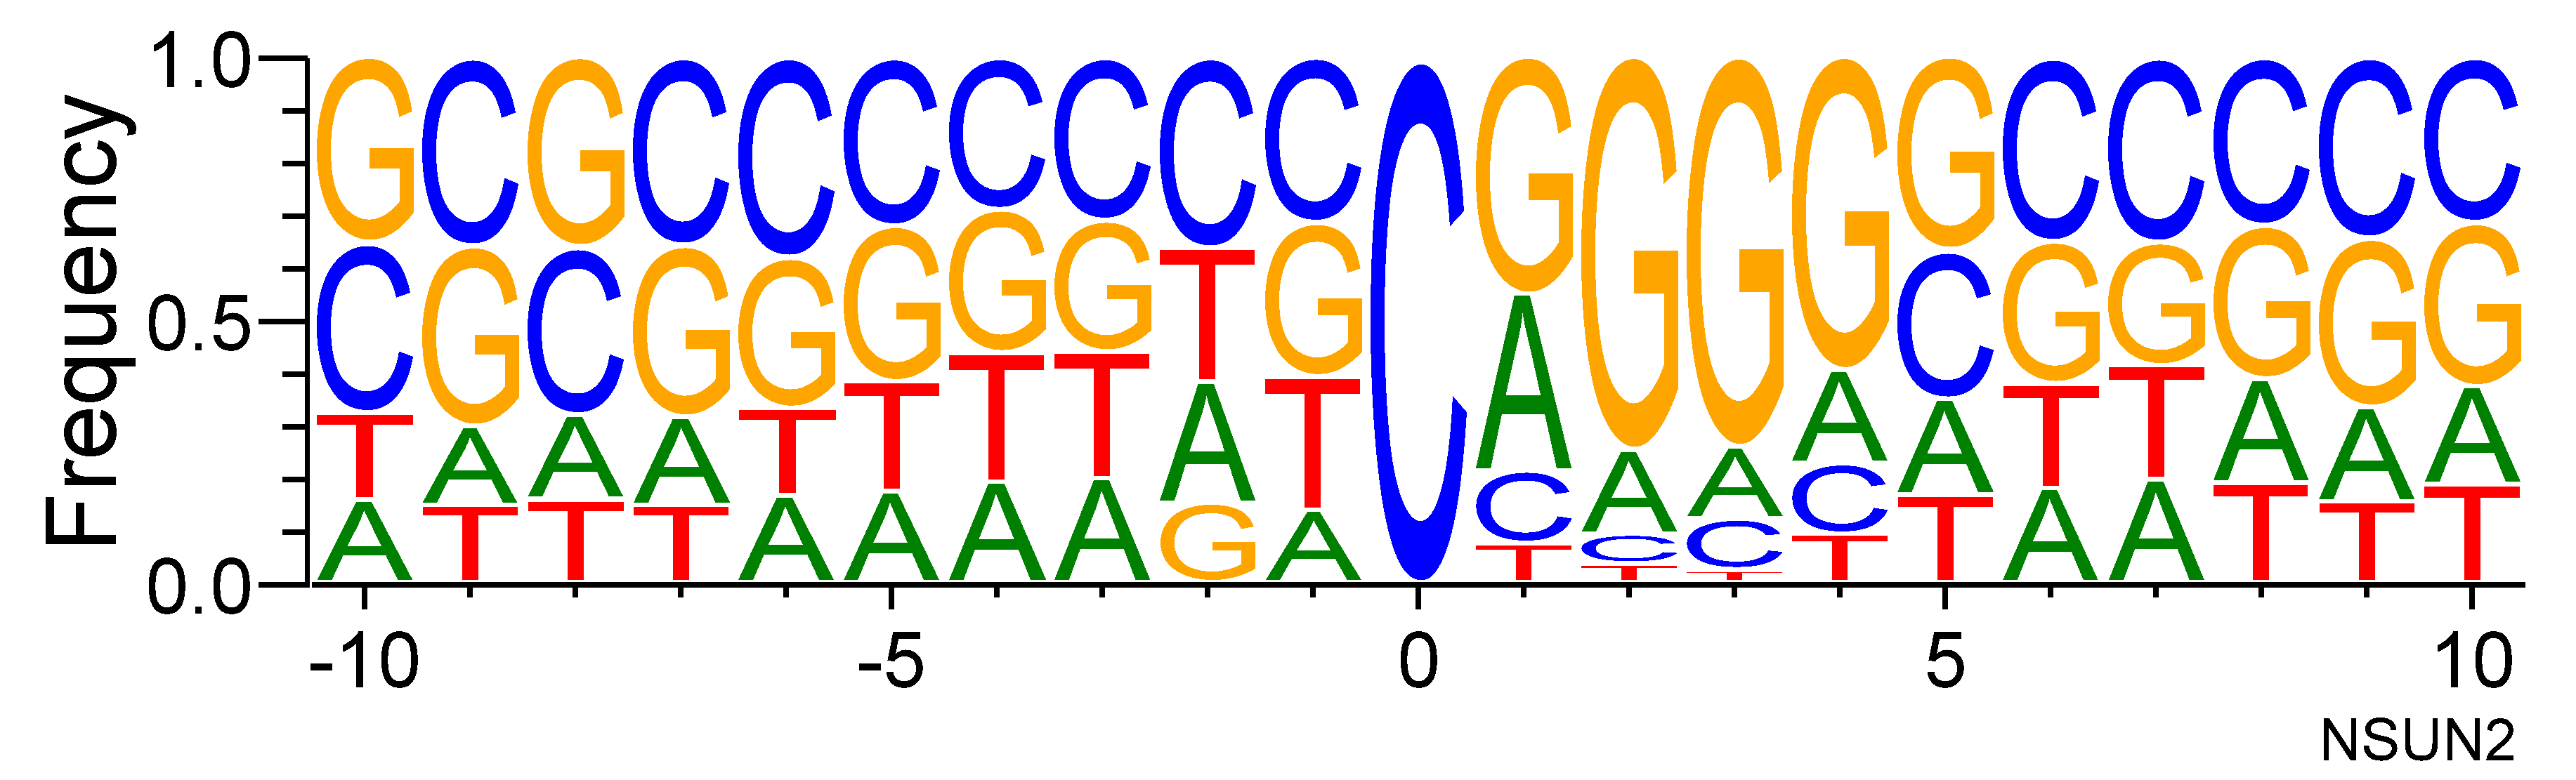

In [36]:
Image(filename='NSUN2.F10.png', width = 400, height = 200) 

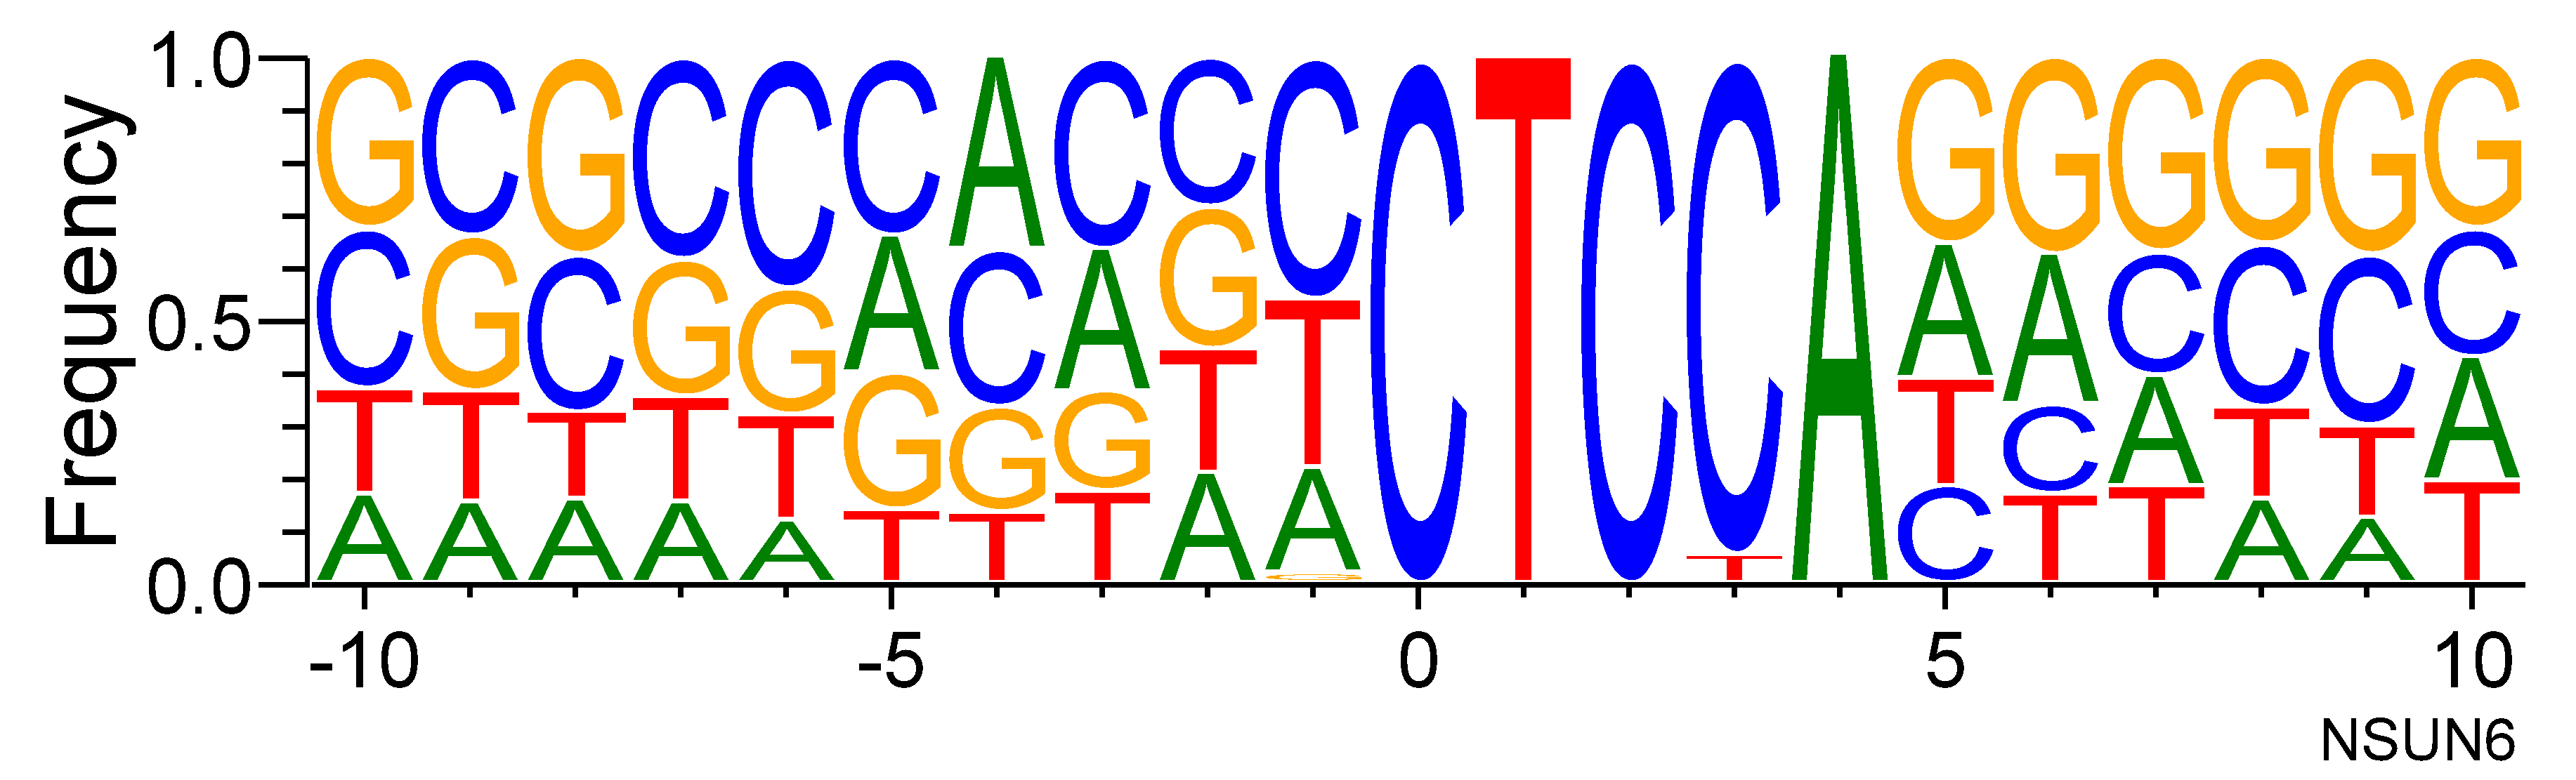

In [37]:
Image(filename='NSUN6.F10.png', width = 400, height = 200)

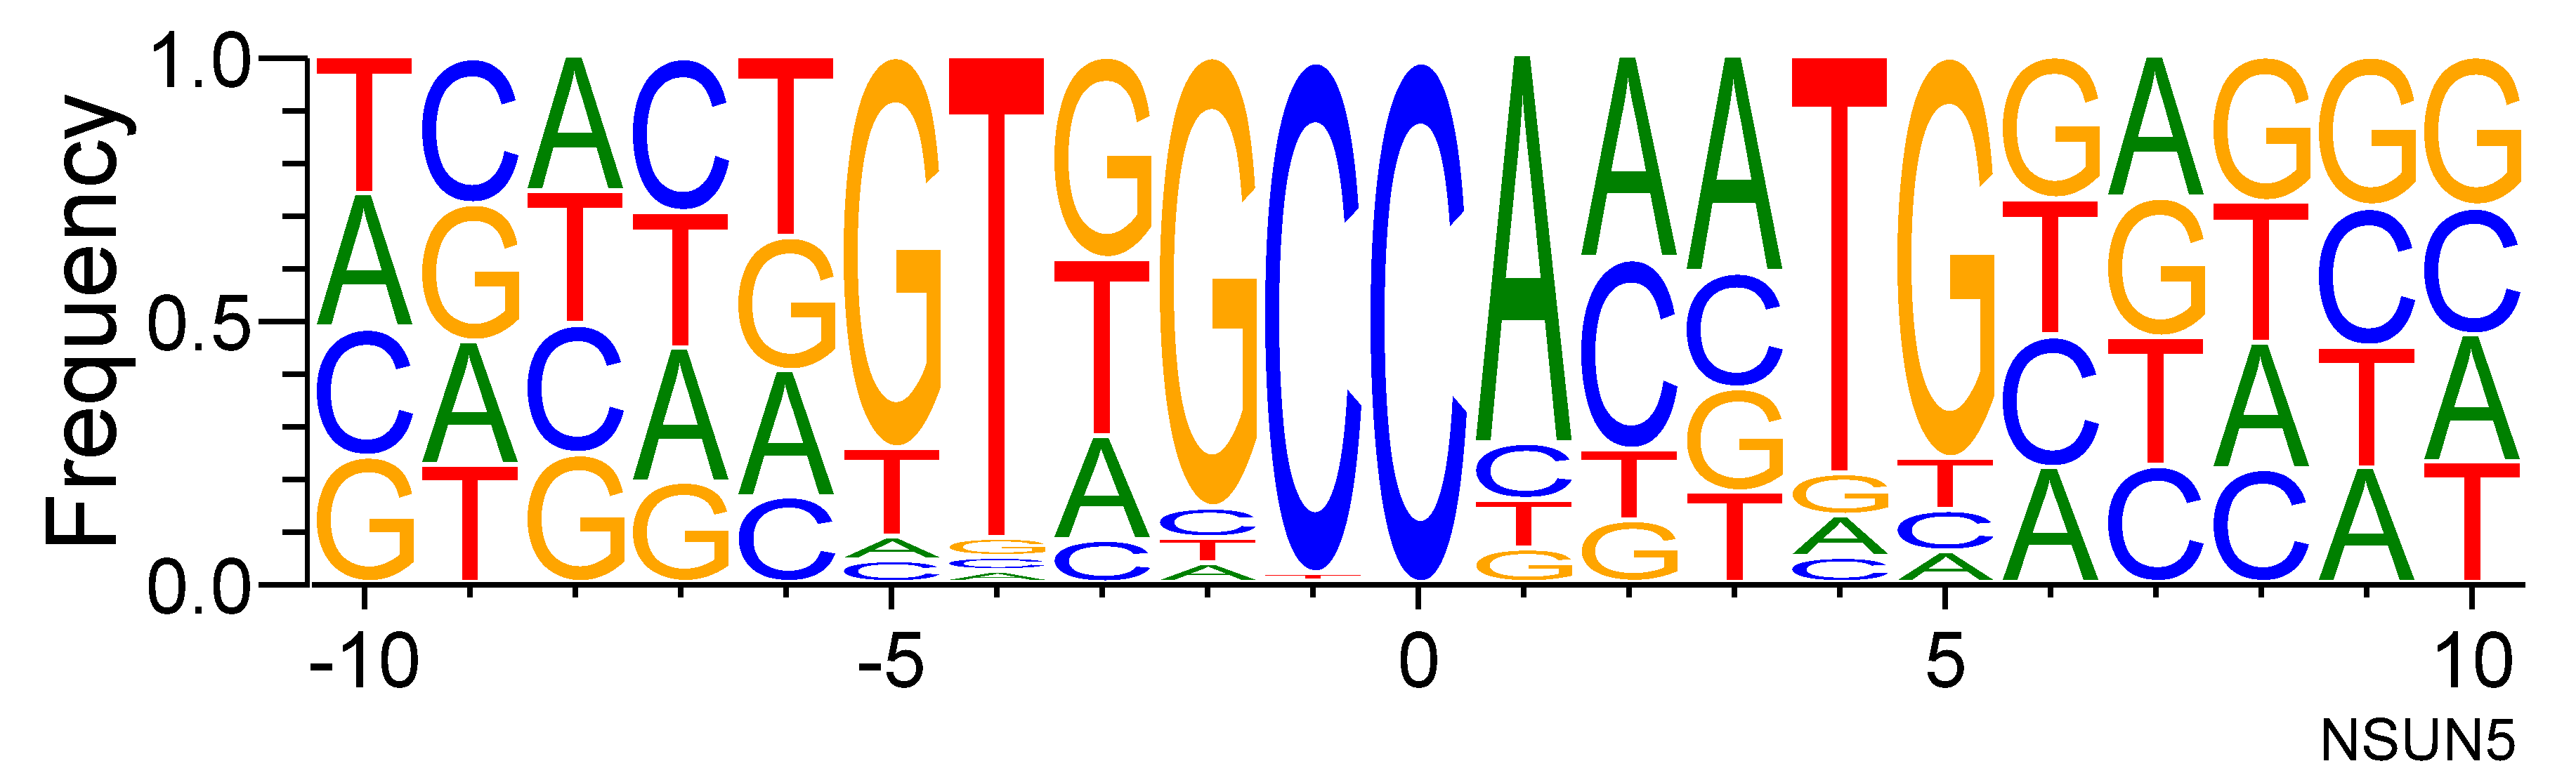

In [38]:
Image(filename='NSUN5.F10.png', width = 400, height = 200)

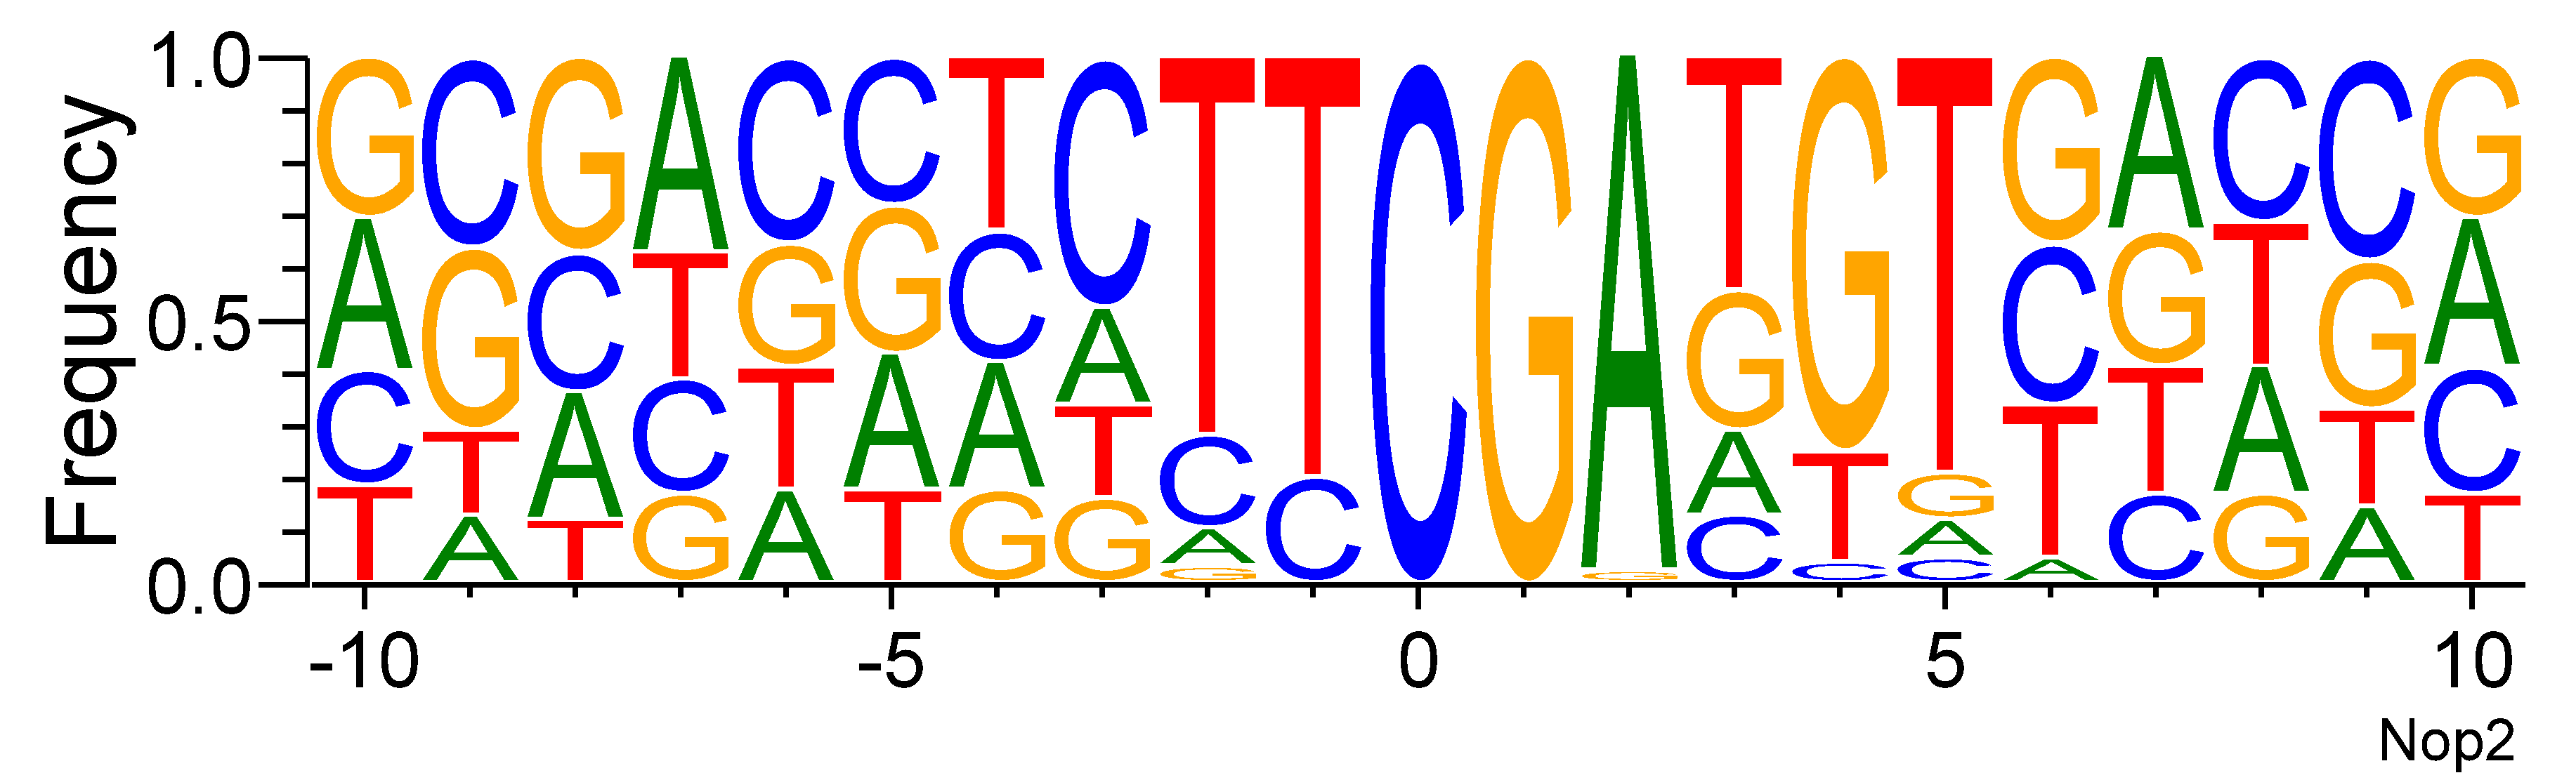

In [39]:
Image(filename='Nop2.F10.png', width = 400, height = 200) 

### 4.3 Store the data into a .h5 file

In [40]:
with h5py.File("dataset_m5C_21nt.h5", "w") as h5file:
    h5file.create_dataset("IDs", data=np.array(IDs))
    # h5file.create_dataset("Labels", data=np.array(labels))
    h5file.create_dataset("Labels_category", data=np.array(Labels_int))
    h5file.create_dataset("Labels_category_onehot", data=np.array(Labels_onehot))
    # h5file.create_dataset("Sequences_1x5", data=np.array(Sequences))
    h5file.create_dataset("Sequences_1x5_onehot", data=np.array(Sequences_onehot))

## 5. Go back to tables and check the levels

### 5.1 Noc-treated HeLa cells

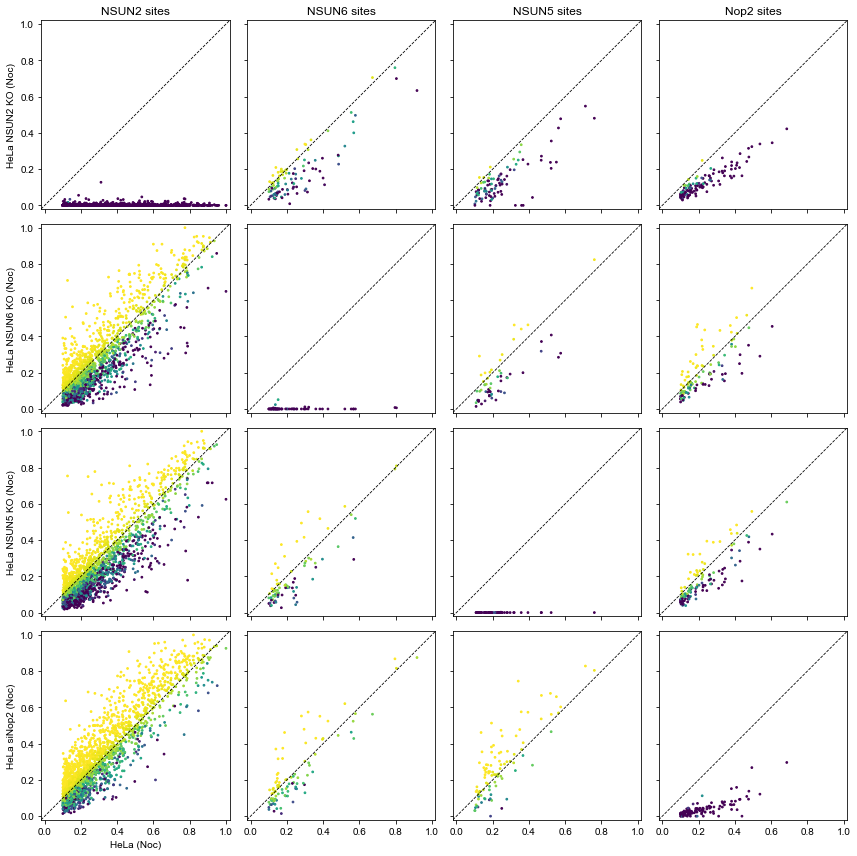

In [41]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12,12))

for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[0][i], df_Noc, "WT_Noc", "KO_N2", indexes=filter, ylabel="HeLa NSUN2 KO (Noc)")
    else:
        draw_one(axes[0][i], df_Noc, "WT_Noc", "KO_N2", indexes=filter)
    axes[0][i].set_title(title)
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[1][i], df_Noc, "WT_Noc", "KO_N6", indexes=filter, ylabel="HeLa NSUN6 KO (Noc)")
    else:
        draw_one(axes[1][i], df_Noc, "WT_Noc", "KO_N6", indexes=filter)

for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[2][i], df_Noc, "WT_Noc", "KO_N5", indexes=filter, ylabel="HeLa NSUN5 KO (Noc)")
    else:
        draw_one(axes[2][i], df_Noc, "WT_Noc", "KO_N5", indexes=filter, xlabel="")

for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[3][i], df_Noc, "WT_Noc", "si_N1", indexes=filter, xlabel="HeLa (Noc)", ylabel="HeLa siNop2 (Noc)")
    else:
        draw_one(axes[3][i], df_Noc, "WT_Noc", "si_N1", indexes=filter)

plt.tight_layout()
plt.savefig("HeLa_Noc_sites.pdf")

### 5.2 HEK293T, HeLa, and HepG2 (KO NSUN6)

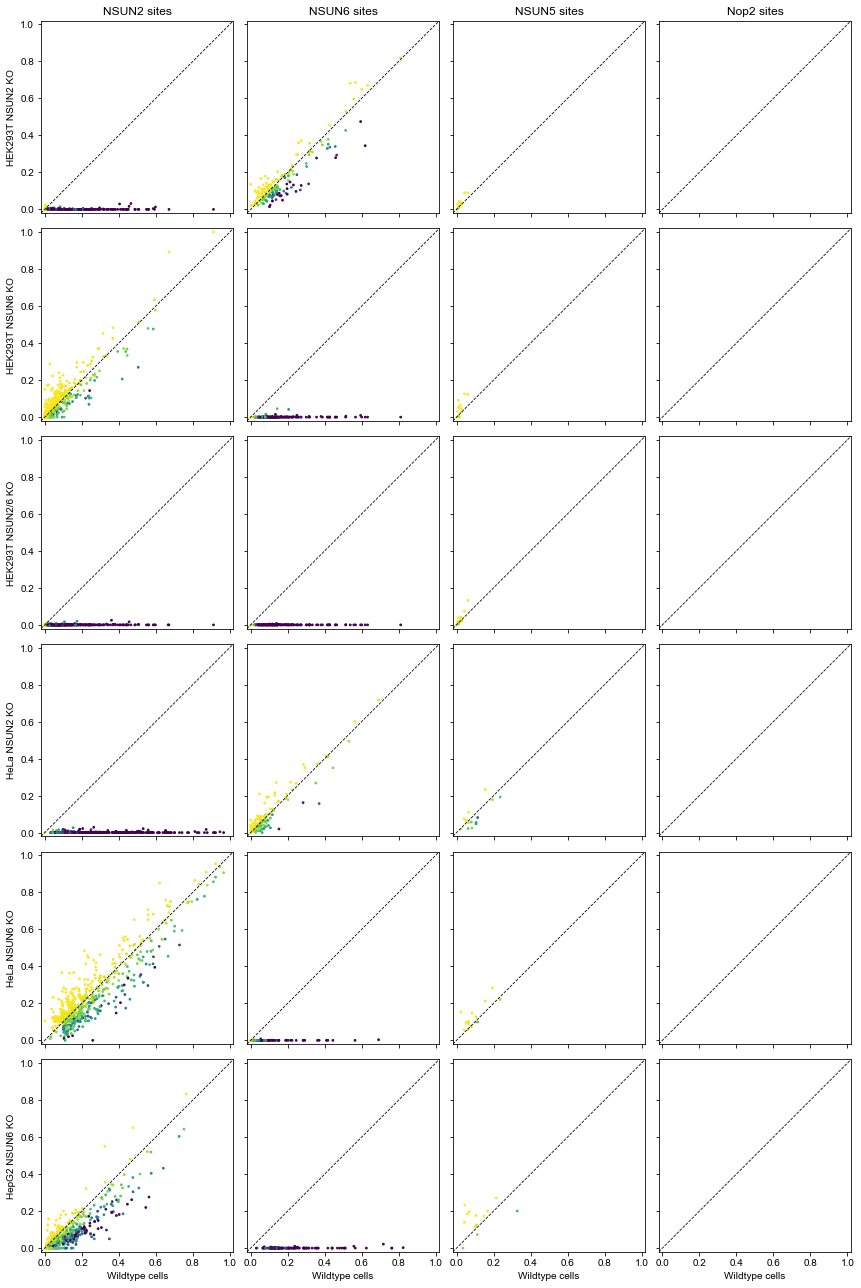

In [42]:
fig, axes = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(12,18))

for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[0][i], df_cells, "293T", "293T_KO_N2", indexes=filter, ylabel="HEK293T NSUN2 KO")
    else:
        draw_one(axes[0][i], df_cells, "293T", "293T_KO_N2", indexes=filter)
    axes[0][i].set_title(title)
    
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[1][i], df_cells, "293T",  "293T_KO_N6", indexes=filter, ylabel="HEK293T NSUN6 KO")
    else:
        draw_one(axes[1][i], df_cells, "293T",  "293T_KO_N6", indexes=filter)
    
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[2][i], df_cells, "293T",  "293T_KO_N26", indexes=filter, ylabel="HEK293T NSUN2/6 KO")
    else:
        draw_one(axes[2][i], df_cells, "293T",  "293T_KO_N26", indexes=filter)
    
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[3][i], df_cells, "HeLa",  "HeLa_KO_N2", indexes=filter, ylabel="HeLa NSUN2 KO")
    else:
        draw_one(axes[3][i], df_cells, "HeLa",  "HeLa_KO_N2", indexes=filter)
    
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[4][i], df_cells, "HeLa",  "HeLa_KO_N6", indexes=filter, ylabel="HeLa NSUN6 KO")
    else:
        draw_one(axes[4][i], df_cells, "HeLa",  "HeLa_KO_N6", indexes=filter)
        
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[5][i], df_cells, "HepG2",  "HepG2_KO_N6", indexes=filter, ylabel="HepG2 NSUN6 KO", xlabel="Wildtype cells")
    else:
        draw_one(axes[5][i], df_cells, "HepG2",  "HepG2_KO_N6", indexes=filter, xlabel="Wildtype cells")
plt.tight_layout()
plt.savefig("cell_lines_sites.pdf")

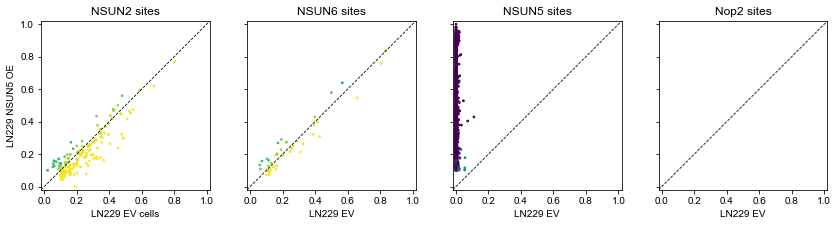

In [43]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12,3))
for i, filter, title in zip(*[[0,1,2,3], [NSUN2_filtered, NSUN6_filtered, NSUN5_filtered, Nop2_filtered], ["NSUN2 sites", "NSUN6 sites", "NSUN5 sites", "Nop2 sites"]]):
    if i == 0:
        draw_one(axes[i], df_LN229, "LN229_EV",  "LN229_OE", indexes=filter, ylabel="LN229 NSUN5 OE", xlabel="LN229 EV cells", alternative="greater")
    else:
        draw_one(axes[i], df_LN229, "LN229_EV",  "LN229_OE", indexes=filter, xlabel="LN229 EV", alternative="greater")
    axes[i].set_title(title)
plt.tight_layout()
plt.savefig("LN229_sites.pdf")